# Kaggle Competition: Predict Hotel Cancellations

In [1]:
# All code in this cell was provided by the course instructor

import pandas as pd
import numpy as np
import pickle

################################
# Load the data
################################
data = pickle.load( open( "./data/a5_q1.pkl", "rb" ) )

y_train = data['y_train']
X_train_original = data['X_train'] # Original dataset
X_train_ohe = data['X_train_ohe']  # One-hot-encoded dataset

X_test_original = data['X_test']
X_test_ohe = data['X_test_ohe']

################################
# Produce submission
################################

def create_submission(confidence_scores, save_path):
    '''Creates an output file of submissions for Kaggle
    
    Parameters
    ----------
    confidence_scores : list or numpy array
        Confidence scores (from predict_proba methods from classifiers) or
        binary predictions (only recommended in cases when predict_proba is 
        not available)
    save_path : string
        File path for where to save the submission file.
    
    Example:
    create_submission(my_confidence_scores, './data/submission.csv')

    '''
    import pandas as pd

    submission = pd.DataFrame({"score":confidence_scores})
    submission.to_csv(save_path, index_label="id")

### Preprocessing

<font size="4"> I spent a lot of time trying different ways to preprocess the data. As a result, I think that one of the main learning outcomes I had from this assignment was that I gained quite a few insights into how to preprocess data in a more sophisticated way. The use of sklearn's pipelines makes my code way cleaner and gives me 100% confidence that I haven't forgotten to apply a preprocessing step to the training as well as the test data (and also that I haven't cheated by, for example, fitting a KNNImputer to the test data instead of using the KNNImputer that was fit to the training data to transform the test set).
    
<font size="4"> Originally, I deleted a lot of data from the dataset. I was very wary of the curse of dimensionality and did everything I could to reduce the number of columns in the dataset. I dropped about 800 columns by finding all the one-hot encoded columns containing fewer than 40 ones. In the end, I ended up scrapping this preprocessing step and just used all of the columns. The performance of my model didn't suffer.
    
<font size="4"> So what preprocessing steps did I actually use? For each of the two models I trainined (random forest and boosted decision trees), I first used a KNNImputer to impute missing values. This is a more sophisticated imputation method than simpy replacing missing values with the mean or median. For each model, I actually tuned the number of neighbors that I used in my KNNImputer to try and squeeze out a bit more performance.
    
<font size="4"> After imputing with KNN, I used a StandardScaler to normalize each feature. This is often helpful for a wide variety of types of models, and it almost never hurts model performance (the one exception I know of is that it doesn't make sense to normalize image data that will be fed through a convolutional neural network).

### Model Training

<font size="4"> My strategy was to find the best-performing version of a random forest model and a boosted decision tree model that I could. I'm attracted to these models because they are more innately interpretable than other models and achieve very competitive results. I also tried tuning a multi-layer perceptron and a support vector classifier, but these models took a very long time to train, and I had already achieved very good performence with my ensemble models.
    
<font size="4"> I tuned the hyperparameters of each model (as well as the n_neighbors parameter of the KNNImputers) using stratified k-folds cross-validation. I chose to use stratified k-folds because the data are fairly imbalanced (about a 60/40 split). For a while, I couldn't achieve better than about 65% classification accuracy. As soon as I shuffled the data within the cross-validation iterator object (named "cv" in the code below), performance jumped to over 95%. I also chose to do random search over the hyperparameter space instead of grid search in order to decrease the amount of training time.
    
<font size="4"> Since the models took a long time to train, I focused my efforts of what I believe are the most important hyperparameters for each model. For the random forest classifier, I tuned the number of trees in the forest. It turned out that using just 1 neighbor for the KNNImputer and 750 trees achieved the best results. For the boosted decision tree ensemble, I tuned the learning rate as well as the number of trees. In this case, it turned out that using 10 neighbors to impute, a learning rate of 0.1, and 750 trees yielded the best results.

In [2]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Use the one-hot encoded version of the dataset
X_train = X_train_ohe
X_test = X_test_ohe

In [4]:
# Tuning hyperparameters for the random forest classifier
cv = StratifiedKFold(5, shuffle=True, random_state=1)

RFC_pipe = Pipeline([
                    ("imputer", KNNImputer()),
                    ("scaler", StandardScaler()),
                    ("RFC", RandomForestClassifier(n_jobs=-1))
])

# Hyperparameter search space
RFC_param_dist = {
            "imputer__n_neighbors": [1, 2, 3, 5, 10],
            "RFC__n_estimators": [250, 500, 750, 1000]
}

# Search the above space
RFC_rand_search = RandomizedSearchCV(RFC_pipe,
                                     param_distributions=RFC_param_dist,
                                     cv=cv,
                                     scoring="roc_auc",
                                     n_iter=20)
RFC_rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('RFC',
                                              RandomForestClassifier(n_jobs=-1))]),
                   n_iter=20,
                   param_distributions={'RFC__n_estimators': [250, 500, 750,
                                                              1000],
                                        'imputer__n_neighbors': [1, 2, 3, 5,
                                                                 10]},
                   scoring='roc_auc')

In [5]:
# Tuning hyperparameters for boosting
boost_pipe = Pipeline([
                        ("imputer", KNNImputer()),
                        ("scaler", StandardScaler()),
                        ("boost", HistGradientBoostingClassifier())
])

# Hyperparameter search space
boost_param_dist = {
                    "imputer__n_neighbors": [1, 2, 3, 5, 10],
                    "boost__learning_rate": [0.01, 0.1, 0.3, 0.5, 1],
                    "boost__max_iter": [250, 500, 750, 1000]
}

# Search the above space
boost_rand_search = RandomizedSearchCV(boost_pipe,
                                       param_distributions=boost_param_dist,
                                       cv=cv,
                                       scoring="roc_auc",
                                       n_iter=20)
boost_rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                             ('scaler', StandardScaler()),
                                             ('boost',
                                              HistGradientBoostingClassifier())]),
                   n_iter=20,
                   param_distributions={'boost__learning_rate': [0.01, 0.1, 0.3,
                                                                 0.5, 1],
                                        'boost__max_iter': [250, 500, 750,
                                                            1000],
                                        'imputer__n_neighbors': [1, 2, 3, 5,
                                                                 10]},
                   scoring='roc_auc')

In [6]:
# The best-performing pipelines returned by RandomSearchCV
RFC_best = Pipeline([
                    ("imputer", KNNImputer(n_neighbors=1)),
                    ("scaler", StandardScaler()),
                    ("RFC", RandomForestClassifier(n_estimators=750, n_jobs=-1))
])

boost_best = Pipeline([
                     ("imputer", KNNImputer(n_neighbors=10)),
                     ("scaler", StandardScaler()),
                     ("boost", HistGradientBoostingClassifier(max_iter=750, learning_rate=0.1))
])

In [7]:
# Creating submissions using the best-performing pipelines from RandomizedSearchCV
RFC_best.fit(X_train, y_train)
RFC_pred = RFC_best.predict_proba(X_test)[:,1]
create_submission(RFC_pred, "./data/rfc_sub.csv")

boost_best.fit(X_train, y_train)
boost_pred = boost_best.predict_proba(X_test)[:,1]
create_submission(boost_pred, "./data/boost_sub.csv")

### Measuring classification performance and computational efficiency for 5 different models

In [8]:
# Deafult random forest pipeline
RFC_default = Pipeline([
                      ("imputer", KNNImputer()),
                      ("scaler", StandardScaler()),
                      ("RFC", RandomForestClassifier())
])

# Default boosting pipeline
boost_default = Pipeline([
                        ("imputer", KNNImputer()),
                        ("scaler", StandardScaler()),
                        ("boost", HistGradientBoostingClassifier())
])

# Random forest with 10 neighbors for imputing and 1000 trees
RFC_large = Pipeline([
                    ("imputer", KNNImputer(n_neighbors=10)),
                    ("scaler", StandardScaler()),
                    ("RFC", RandomForestClassifier(n_estimators=1000))
])

pipes = [RFC_best,
         boost_best,
         RFC_default,
         boost_default,
         RFC_large]

pipe_names = ["RFC_best",
              "boost_best",
              "RFC_default",
              "boost_default",
              "RFC_large"]

In [9]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import timeit

X_tr, X_val, y_tr, y_val = train_test_split(X_train,
                                            y_train,
                                            test_size=0.20,
                                            random_state=1)


fit_times = []
pred_times = []
fprs = []
tprs = []
precisions = []
recalls = []
auc_scores = []
APs = []

for pipe in pipes:
    # Fit to training data
    start_fit = timeit.default_timer()
    pipe.fit(X_tr, y_tr)
    elapsed_fit = round(timeit.default_timer() - start_fit, 3)
    fit_times.append(elapsed_fit)
    # Make predictions
    start_pred = timeit.default_timer()
    pred = pipe.predict_proba(X_val)[:,1]
    elapsed_pred = round(timeit.default_timer() - start_pred, 3)
    pred_times.append(elapsed_pred)
    # Get fpr and tpr
    fpr, tpr, _ = roc_curve(y_val, pred)
    fprs.append(fpr)
    tprs.append(tpr)
    # Get precision and recall
    precision, recall, _ = precision_recall_curve(y_val, pred)
    precisions.append(precision)
    recalls.append(recall)
    # Get AUC score
    auc_scores.append(roc_auc_score(y_val, pred))
    # Get average precision
    APs.append(average_precision_score(y_val, pred))

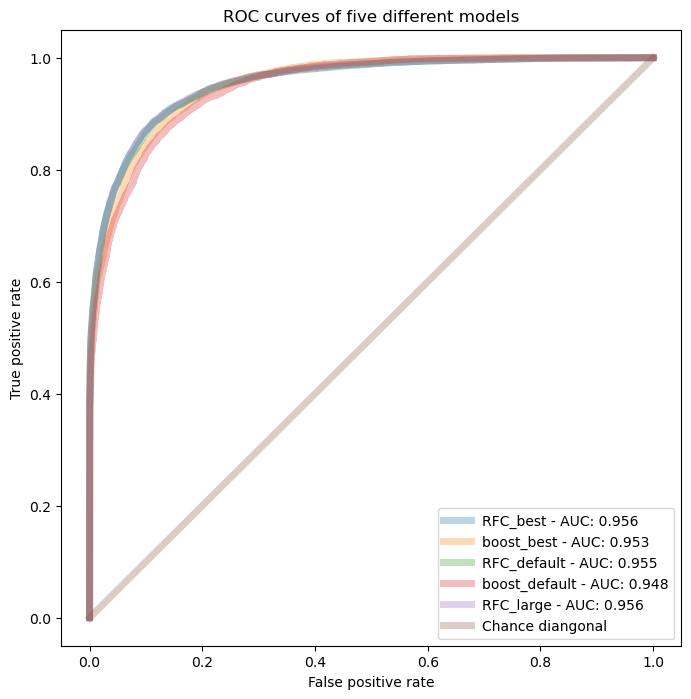

In [10]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(5):
    ax.plot(fprs[i],
            tprs[i],
            label=pipe_names[i] + " - AUC: " + str(round(auc_scores[i], 3)),
            linewidth=5,
            alpha=0.3)

ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        linewidth=5,
        label="Chance diangonal",
        alpha=0.3)

ax.legend();
ax.set_xlabel("False positive rate");
ax.set_ylabel("True positive rate");
ax.set_title("ROC curves of five different models");

In [11]:
fraction_of_ones_val = y_val.value_counts()[1] / y_val.size

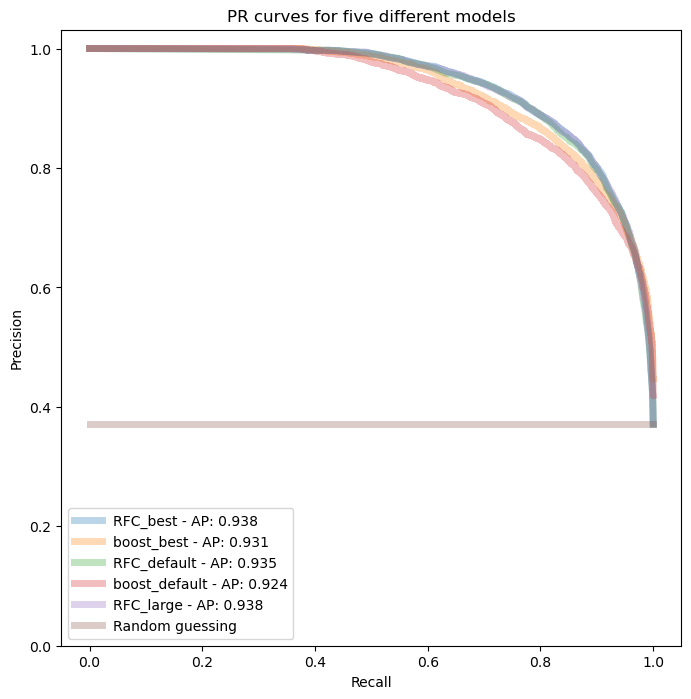

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(5):
    ax.plot(recalls[i],
            precisions[i],
            label=pipe_names[i] + " - AP: " + str(round(APs[i], 3)),
            linewidth=5,
            alpha=0.3)
    
ax.plot(np.linspace(0, 1, 100),
        fraction_of_ones_val * np.ones(100),
        linewidth=5,
        alpha=0.3,
        label="Random guessing")
ax.set_ylim(ymin=0)
ax.set_xlabel("Recall");
ax.set_ylabel("Precision");
ax.set_title("PR curves for five different models");
ax.legend();

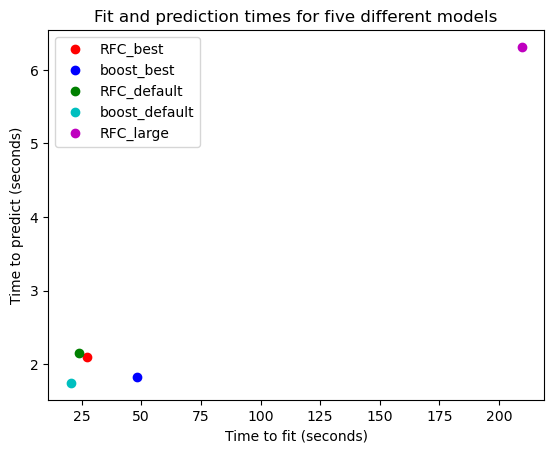

In [13]:
fig, ax = plt.subplots()

ax.plot(fit_times[0], pred_times[0], "ro", label=pipe_names[0]);
ax.plot(fit_times[1], pred_times[1], "bo", label=pipe_names[1]);
ax.plot(fit_times[2], pred_times[2], "go", label=pipe_names[2]);
ax.plot(fit_times[3], pred_times[3], "co", label=pipe_names[3]);
ax.plot(fit_times[4], pred_times[4], "mo", label=pipe_names[4]);
ax.legend();
ax.set_xlabel("Time to fit (seconds)");
ax.set_ylabel("Time to predict (seconds)");
ax.set_title("Fit and prediction times for five different models");

<font size="4"> The RFC_large model (10 neighbors in the KNNImputer and 1000 trees performs very similarly to RFC_best). In fact, before rounding RFC_large achieves the best AUC and AP out of all of the models, though it's only a tiny fraction better than RFC_best. Random search must not have tried that combination of hyperparameters. RFC_large takes much longer to train and to make predictions compared to all the other models, though boost_best takes considerably longer to fit than do the remaining three models.